### Import Packages

In [1]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score

from sklearn.impute import KNNImputer
from xgboost import XGBClassifier

### Import Dataset & Read Dataset

In [81]:
# read datasets & display head
train_df = pd.read_csv(r'/kaggle/input/widsdatathon2024-challenge1/training.csv')
test_df = pd.read_csv(r"/kaggle/input/widsdatathon2024-challenge1/test.csv")
train_df.head()

,patient_id,patient_race,payer_type,patient_state,patient_zip3,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,...,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02,DiagPeriodL90D
0,475714,NaN,MEDICAID,CA,924,84,F,NaN,C50919,Malignant neoplasm of unsp site of unspecified...,...,12.871429,22.542857,10.100000,27.814286,11.200000,3.500000,52.237210,8.650555,18.606528,1
1,349367,White,COMMERCIAL,CA,928,62,F,28.49,C50411,Malig neoplm of upper-outer quadrant of right ...,...,8.957576,10.109091,8.057576,30.606061,7.018182,4.103030,42.301121,8.487175,20.113179,1
2,138632,White,COMMERCIAL,TX,760,43,F,38.09,C50112,Malignant neoplasm of central portion of left ...,...,11.253333,9.663333,3.356667,31.394915,15.066667,7.446667,40.108207,7.642753,14.839351,1
3,617843,White,COMMERCIAL,CA,926,45,F,NaN,C50212,Malig neoplasm of upper-inner quadrant of left...,...,8.845238,8.688095,5.280952,27.561905,4.404762,4.809524,42.070075,7.229393,15.894123,0
4,817482,NaN,COMMERCIAL,ID,836,55,F,NaN,1749,"Malignant neoplasm of breast (female), unspeci...",...,15.276000,11.224000,1.946000,26.170213,12.088000,13.106000,41.356058,4.110749,11.722197,0


In [4]:
# create a copy for the second method of imputation using k-nearest neighbors
train_KNN_df = train_df.copy()

### Exploratory Data Analysis

In [78]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12906 entries, 0 to 12905
Data columns (total 83 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   patient_id                             12906 non-null  int64  
 1   patient_race                           6521 non-null   object 
 2   payer_type                             11103 non-null  object 
 3   patient_state                          12855 non-null  object 
 4   patient_zip3                           12906 non-null  int64  
 5   patient_age                            12906 non-null  int64  
 6   patient_gender                         12906 non-null  object 
 7   bmi                                    3941 non-null   float64
 8   breast_cancer_diagnosis_code           12906 non-null  object 
 9   breast_cancer_diagnosis_desc           12906 non-null  object 
 10  metastatic_cancer_diagnosis_code       12906 non-null  object 
 11  me

In [79]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5792 entries, 0 to 5791
Data columns (total 82 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   patient_id                             5792 non-null   int64  
 1   patient_race                           2891 non-null   object 
 2   payer_type                             5032 non-null   object 
 3   patient_state                          5771 non-null   object 
 4   patient_zip3                           5792 non-null   int64  
 5   patient_age                            5792 non-null   int64  
 6   patient_gender                         5792 non-null   object 
 7   bmi                                    1777 non-null   float64
 8   breast_cancer_diagnosis_code           5792 non-null   object 
 9   breast_cancer_diagnosis_desc           5792 non-null   object 
 10  metastatic_cancer_diagnosis_code       5792 non-null   object 
 11  meta

In [6]:
train_df['patient_gender'].value_counts()

patient_gender
F    12906
Name: count, dtype: int64

In [7]:
train_df.describe()

,patient_id,patient_zip3,patient_age,bmi,population,density,age_median,age_under_10,age_10_to_19,age_20s,...,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02,DiagPeriodL90D
count,12906.000000,12906.000000,12906.000000,3941.000000,12905.000000,12905.000000,12905.000000,12905.000000,12905.000000,12905.000000,...,12905.000000,12902.000000,12902.000000,12905.000000,12905.000000,12905.000000,12877.000000,12877.000000,12877.000000,12906.000000
mean,547381.196033,573.754300,59.183326,28.984539,20744.441237,1581.950419,40.502259,11.122784,12.945265,13.290376,...,13.335299,13.406950,4.474956,27.978387,8.575284,7.083376,39.822352,7.475221,16.098988,0.624516
std,260404.959974,275.447534,13.335216,5.696906,13886.903756,2966.305306,4.036963,1.512376,1.923974,3.354103,...,3.690949,5.222495,4.837085,5.083939,4.203482,3.109022,3.559492,1.516499,5.842501,0.484266
min,100063.000000,101.000000,18.000000,14.000000,635.545455,0.916667,20.600000,0.000000,6.314286,5.925000,...,4.600000,3.433333,0.000000,12.460784,2.440000,1.200000,30.939316,2.636008,2.760371,0.000000
25%,321517.000000,331.000000,50.000000,24.660000,9463.896552,171.857143,37.129825,10.160000,11.741176,11.013415,...,10.270492,9.663333,0.994444,24.933333,5.618750,4.929688,37.698880,6.651215,11.280694,0.000000
50%,543522.000000,554.000000,59.000000,28.190000,19154.190480,700.337500,40.639344,11.039216,12.923944,12.538095,...,12.884000,12.177778,2.747222,27.788235,7.465714,6.847059,39.108249,7.686577,15.589148,1.000000
75%,772671.750000,846.000000,67.000000,32.920000,30021.278690,1666.515385,42.934783,12.190000,14.019767,14.971053,...,15.555405,16.635556,5.976000,30.709375,10.617442,8.620000,41.136513,8.276922,20.801880,1.000000
max,999896.000000,999.000000,91.000000,85.000000,71374.131580,21172.000000,54.570000,17.675000,35.300000,62.100000,...,35.155556,38.347826,26.755000,48.020000,27.566102,25.200000,52.237210,11.169408,31.504775,1.000000


In [72]:
test_df.describe()

,patient_id,patient_state,patient_zip3,patient_age,patient_gender,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,Region,Division,...,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02
count,5792.000000,5792.000000,5792.000000,5792.000000,5792.0,5792.000000,5792.000000,5792.000000,5792.000000,5792.000000,...,5792.000000,5792.000000,5792.000000,5792.000000,5792.000000,5792.000000,5792.000000,5792.000000,5792.000000,5792.000000
mean,549946.787983,20.393128,570.217887,59.274862,0.0,26.294544,25.087707,10.540055,1.627072,3.863087,...,18.036444,13.483574,13.435855,4.292997,27.915686,8.636586,7.171897,39.788771,7.435363,15.936645
std,260988.833446,13.564404,275.314510,13.076323,0.0,14.350784,12.503948,10.785940,1.169644,2.767526,...,16.716396,3.693358,5.105064,4.673524,4.997893,4.142770,3.107104,3.482556,1.526806,5.887529
min,100266.000000,0.000000,101.000000,18.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.194444,4.600000,3.433333,0.000000,13.722078,2.440000,1.200000,30.939316,2.636008,2.760371
25%,320284.500000,8.000000,329.000000,50.000000,0.0,10.000000,14.000000,3.000000,0.000000,1.000000,...,4.698529,10.388889,9.995000,0.878049,24.932500,5.772727,5.078571,37.722740,6.590523,11.100666
50%,553042.000000,20.000000,554.000000,59.000000,0.0,25.500000,30.000000,3.000000,2.000000,5.000000,...,11.842623,13.093333,12.218182,2.690196,27.561905,7.468000,7.070370,39.132788,7.660674,15.246437
75%,778552.250000,32.000000,836.000000,67.000000,0.0,40.000000,36.000000,21.000000,3.000000,6.000000,...,27.594872,15.802128,16.438889,5.863830,30.709375,10.820000,8.774510,41.058349,8.276922,20.348878
max,999890.000000,46.000000,996.000000,91.000000,0.0,45.000000,45.000000,35.000000,4.000000,9.000000,...,91.005085,35.155556,38.347826,22.591667,48.020000,27.566102,21.426667,52.237210,11.169408,31.504775


In [90]:
# train_df_cols = train_df.columns
# test_df2 = test_df.reindex(columns = train_df_cols)
# test_df2.head()

same_cols = [col for col in train_df.columns if col in test_df.columns]


sorted_cols = sorted(train_df.columns)
train_df = train_df.reindex(columns = sorted_cols)
test_df = test_df.reindex(columns = sorted_cols)

train_df.head()


,DiagPeriodL90D,Division,N02,Ozone,PM25,Region,age_10_to_19,age_20s,age_30s,age_40s,...,race_native,race_other,race_pacific,race_white,rent_burden,rent_median,self_employed,unemployment_rate,veteran,widowed
0,1,Pacific,18.606528,52.237210,8.650555,West,15.542857,17.614286,14.014286,11.614286,...,1.485714,27.114286,0.342857,44.100000,37.442857,1165.000000,13.428571,8.471429,3.500000,4.442857
1,1,Pacific,20.113179,42.301121,8.487175,West,13.354545,14.230303,13.418182,13.333333,...,0.587879,11.645455,0.300000,54.030303,34.753125,2003.125000,15.224242,5.103030,4.103030,4.651515
2,1,West South Central,14.839351,40.108207,7.642753,South,14.463333,12.531667,13.545000,12.860000,...,0.463333,3.816667,0.146667,75.820000,29.358491,1235.907407,13.722034,4.560000,7.446667,4.710000
3,0,Pacific,15.894123,42.070075,7.229393,West,12.135714,12.538095,12.464286,12.650000,...,0.430952,5.428571,0.252381,65.014286,32.030952,2354.738095,18.502381,5.264286,4.809524,4.623810
4,0,Mountain,11.722197,41.356058,4.110749,West,13.976000,9.492000,10.364000,12.600000,...,0.760000,5.080000,0.108000,86.712000,27.029730,919.743590,13.029545,4.258000,13.106000,5.406000


In [93]:
# test_df.head()
test_df.drop(columns = 'DiagPeriodL90D', inplace=  True)
test_df.head()

,Division,N02,Ozone,PM25,Region,age_10_to_19,age_20s,age_30s,age_40s,age_50s,...,race_native,race_other,race_pacific,race_white,rent_burden,rent_median,self_employed,unemployment_rate,veteran,widowed
0,East North Central,11.157161,38.724876,7.947165,Midwest,14.088710,10.659677,11.625806,11.208065,15.619355,...,0.119355,0.770968,0.009677,94.793548,23.895455,825.122449,10.655357,3.406557,8.080645,6.583871
1,South Atlantic,13.599985,36.918257,7.838973,South,8.587179,10.684615,11.302564,10.971795,15.823077,...,0.187179,1.841026,0.076923,78.217949,34.957895,1343.394737,11.564103,5.002632,9.302564,8.310256
2,Pacific,20.084231,47.310325,9.595719,West,12.897826,14.121739,13.532609,13.160870,13.378261,...,1.193478,18.858696,0.269565,38.708696,34.595652,1778.000000,15.708696,6.197826,3.810870,4.969565
3,Pacific,20.084231,47.310325,9.595719,West,12.897826,14.121739,13.532609,13.160870,13.378261,...,1.193478,18.858696,0.269565,38.708696,34.595652,1778.000000,15.708696,6.197826,3.810870,4.969565
4,Pacific,21.644261,41.186992,11.166898,West,11.267692,17.233846,17.441538,13.090769,12.304615,...,1.120000,22.135385,0.146154,42.824615,37.367742,1651.145161,21.233333,8.683077,3.030769,4.766154


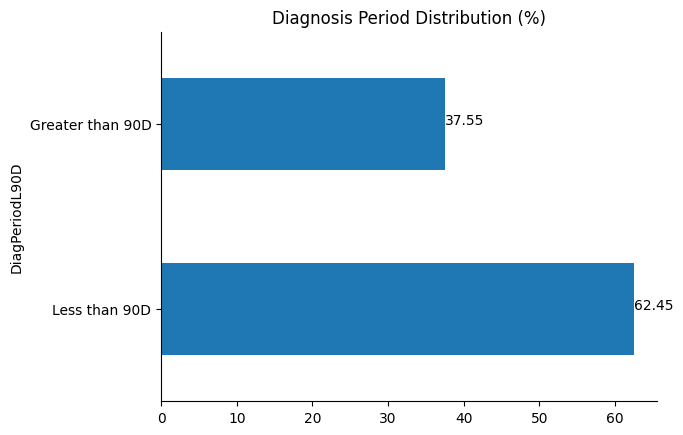

In [8]:
# look at distribution of diagnosis within 90D
diag_dist = train_df['DiagPeriodL90D'].value_counts(normalize = True) * 100

# plotting the distribution
ax = diag_dist.plot(kind = 'barh')
ax.spines[['top', 'right']].set_visible(False)
plt.title('Diagnosis Period Distribution (%)')
plt.yticks(ticks = [0, 1], labels = ['Less than 90D','Greater than 90D'])
for i, v in enumerate(diag_dist):
    ax.annotate('%.2f'%v,(v, i))

In [9]:
# looking at correlation of each feature to DiagPeriodL90D
pd.set_option('display.max_rows', None)
corr_df = train_df.corr(numeric_only = True)
corr_df['DiagPeriodL90D'].sort_values(ascending = False)

DiagPeriodL90D                 1.000000
patient_age                    0.055634
education_bachelors            0.037704
patient_zip3                   0.036372
income_individual_median       0.033206
home_value                     0.030163
education_college_or_above     0.029082
labor_force_participation      0.028169
income_household_100_to_150    0.025316
income_household_median        0.025300
income_household_75_to_100     0.024994
rent_median                    0.024770
self_employed                  0.023837
income_household_six_figure    0.023361
family_dual_income             0.022012
age_40s                        0.020943
income_household_150_over      0.020089
age_30s                        0.019208
education_graduate             0.017765
education_stem_degree          0.016777
race_white                     0.015123
race_pacific                   0.013918
education_some_college         0.012397
race_multiple                  0.011407
male                           0.009984


###! Can drop unnecessary columns here !

In [10]:
drop_col = ['race_native', 'farmer', 'N02', 'divorced', 'rent_burden', 'home_ownership', 'age_median', 'age_60s', 'veteran']

In [29]:
# calculate the percentage of missing data per column
for column in train_df:
  null_count = train_df[column].isnull().sum()
  if null_count > 0:
    percent_nulls = (null_count/train_df.shape[0]) * 100
    print(f"{column}: {percent_nulls:.2f}% null")

for column in test_df:
  null_count = train_df[column].isnull().sum()
  if null_count > 0:
    percent_nulls = (null_count/train_df.shape[0]) * 100
    print(f"{column}: {percent_nulls:.2f}% null")

In [49]:
train_df2 = train_df.copy()
train_KNN_df2 = train_KNN_df.copy()
test_KNN_df = test_df.copy()

for df in [train_df2, train_KNN_df2, test_df, test_KNN_df]:
    columns_to_drop = []  # List to store columns to be dropped
    for column in df.columns:
        null_count = df[column].isnull().sum()
        percent_nulls = (null_count / df.shape[0]) * 100

        if percent_nulls > 1:
            columns_to_drop.append(column)

    # Drop columns from the DataFrame
    df.drop(columns=columns_to_drop, inplace=True)

## METHOD 1: Mean/Mode Imputation

### Address Missing Values

In [94]:
# Separate features into categorical and numerical
cat_cols = train_df.select_dtypes(include = 'object').columns
num_cols = train_df.select_dtypes(include = ['int64', 'float64']).columns

cat_cols_test = test_df.select_dtypes(include = 'object').columns
num_cols_test = test_df.select_dtypes(include = ['int64', 'float64']).columns

# Impute missing numerical cols with mean
for col in cat_cols:
  if col != 'DiagPeriodL90D':
    mode = train_df[col].mode()
    train_df.fillna({col: mode}, inplace = True)

# Impute missing categorical cols with mode
for col in num_cols:
    if col != 'DiagPeriodL90D':
        mean = train_df[col].mean()
        train_df.fillna({col: mean}, inplace = True)
        
for col in cat_cols_test:
    if col != 'DiagPeriodL90D':  
        mode2 = test_df[col].mode()
        test_df.fillna({col: mode2}, inplace = True)        
    
for col in num_cols_test:
    if col != 'DiagPeriodL90D':
        mean2 = test_df[col].mean()
        test_df.fillna({col: mean2}, inplace = True)

### Encode Categorical Features

In [97]:
# initialize LabelEncoder
le = LabelEncoder()

# apply le to categorical columns only
for col in cat_cols:
    train_df[col] = le.fit_transform(train_df[col])
for col in cat_cols_test:    
    test_df[col] = le.fit_transform(test_df[col])

# check that encoding worked
test_df[cat_cols_test].head()

,Division,Region,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,metastatic_first_novel_treatment,metastatic_first_novel_treatment_type,patient_gender,patient_race,patient_state,payer_type
0,0,0,25,6,3,1,0,0,4,14,1
1,6,2,41,38,16,2,1,0,5,8,0
2,5,3,40,35,3,2,1,0,2,4,1
3,5,3,41,38,7,2,1,0,2,4,2
4,5,3,25,6,7,2,1,0,1,4,3


In [96]:
train_df[cat_cols].head()

,Division,Region,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,metastatic_first_novel_treatment,metastatic_first_novel_treatment_type,patient_gender,patient_race,patient_state,payer_type
0,5,3,48,42,41,1,0,0,4,4,1
1,5,3,29,12,3,2,1,0,4,4,0
2,8,2,18,23,3,2,1,0,4,43,0
3,5,3,22,4,3,2,1,0,4,4,0
4,3,3,7,18,3,2,1,0,5,13,0


###Split training.csv into y (target label) and X (all other features)

In [98]:
y = train_df['DiagPeriodL90D']
X = train_df.drop('DiagPeriodL90D', axis = 1) #axis 1 is a column

In [99]:
X.shape

(12906, 82)

### Balance Unevenly Distributed Target Label

In [100]:
# initialize RandomOverSampler
ROS = RandomOverSampler(random_state = 42, # randomization seed to allow for reproducibility
                        sampling_strategy = 'not majority') # look into sampling_strategy

X_over, y_over = ROS.fit_resample(X, y)

In [101]:
# ROS works by duplicating random rows from the minority category (DiagPeriodL90D = 0), which could lead to bias
# this is why there are more rows in the dataset after ROS
X_over.shape

(16120, 82)

### Split training.csv into train and test sets

In [102]:
X_over_train, X_over_test, y_over_train, y_over_test =\
train_test_split(X_over,
                 y_over,
                 test_size = 0.2, # 20% of train.csv will be the test set
                 random_state = 42) # randomization seed

In [103]:
X_over.head()

,Division,N02,Ozone,PM25,Region,age_10_to_19,age_20s,age_30s,age_40s,age_50s,...,race_native,race_other,race_pacific,race_white,rent_burden,rent_median,self_employed,unemployment_rate,veteran,widowed
0,5,18.606528,52.237210,8.650555,3,15.542857,17.614286,14.014286,11.614286,11.557143,...,1.485714,27.114286,0.342857,44.100000,37.442857,1165.000000,13.428571,8.471429,3.500000,4.442857
1,5,20.113179,42.301121,8.487175,3,13.354545,14.230303,13.418182,13.333333,14.060606,...,0.587879,11.645455,0.300000,54.030303,34.753125,2003.125000,15.224242,5.103030,4.103030,4.651515
2,8,14.839351,40.108207,7.642753,2,14.463333,12.531667,13.545000,12.860000,12.770000,...,0.463333,3.816667,0.146667,75.820000,29.358491,1235.907407,13.722034,4.560000,7.446667,4.710000
3,5,15.894123,42.070075,7.229393,3,12.135714,12.538095,12.464286,12.650000,14.847619,...,0.430952,5.428571,0.252381,65.014286,32.030952,2354.738095,18.502381,5.264286,4.809524,4.623810
4,3,11.722197,41.356058,4.110749,3,13.976000,9.492000,10.364000,12.600000,14.992000,...,0.760000,5.080000,0.108000,86.712000,27.029730,919.743590,13.029545,4.258000,13.106000,5.406000


## METHOD 2: Model Imputation with KNNImputer

In [34]:
# initialize LabelEncoder
le = LabelEncoder()

# apply le to categorical columns only
for col in cat_cols:
    train_KNN_df[col] = le.fit_transform(train_KNN_df[col])
#     test_KNN_df[col] = le.fit_transform(test_KNN_df[col])

knn_y = train_KNN_df['DiagPeriodL90D']
knn_X = train_KNN_df.drop('DiagPeriodL90D', axis = 1) #axis 1 is a column

# test_KNN_y = test_KNN_df['DiagPeriodL90D']
# knn_X = test_KNN_df.drop('DiagPeriodL90D', axis = 1) #axis 1 is a column

# initialize imputer
imputer = KNNImputer(n_neighbors = 5, weights = 'uniform', metric = 'nan_euclidean')

# fit the imputer on the dataset
knn_Xtrans = imputer.fit_transform(knn_X)

In [22]:
knn_X_over, knn_y_over = ROS.fit_resample(knn_Xtrans, knn_y)

knn_X_over_train, knn_X_over_test, knn_y_over_train, knn_y_over_test = \
train_test_split(knn_X_over,
                 knn_y_over,
                 test_size = 0.2, # 20% of train.csv will be the test set
                 random_state = 42)

## Modelling with Both Imputation Choices

#### Define Evaluation Function

In [104]:
# function outputs model's performance metrics
def train_eval_model(predictions, y_test):
  accuracy = accuracy_score(y_test, predictions)
  f1 = f1_score(y_test, predictions, average = 'micro')
  precision = precision_score(y_test, predictions, average = 'micro')
  recall = recall_score(y_test, predictions, average = 'micro')
  auc = roc_auc_score(y_test, predictions, multi_class = 'ovr')

  # return a dataframe to visualize the results
  eval_df = pd.DataFrame([[accuracy, f1, precision, recall, auc]], columns = ['accuracy', 'f1 score', 'precision', 'recall', 'auc'])
  return eval_df

#### Using Mean/Mode Imputation

In [105]:
# initialize XGB
xgb_over = XGBClassifier(learning_rate = 0.1)

# fit the model
xgb_over.fit(X_over_train, y_over_train)

#make predictions
xgb_over_predictions = xgb_over.predict(X_over_test)
results = train_eval_model(xgb_over_predictions, y_over_test)
results

,accuracy,f1 score,precision,recall,auc
0,0.781017,0.781017,0.781017,0.781017,0.777955


#### Using KNNImputer

In [37]:
# fit the model
xgb_over.fit(knn_X_over_train, knn_y_over_train)

#make predictions
xgb_over_predictions = xgb_over.predict(knn_X_over_test)
results = train_eval_model(xgb_over_predictions, knn_y_over_test)
results

,accuracy,f1 score,precision,recall,auc
0,0.781638,0.781638,0.781638,0.781638,0.778663


In [71]:
test_df.head()

,patient_id,patient_state,patient_zip3,patient_age,patient_gender,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,Region,Division,...,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02
0,573710,14,467,54,0,25,6,3,0,0,...,3.564516,13.996774,7.985484,0.969355,24.955357,10.838710,8.080645,38.724876,7.947165,11.157161
1,593679,8,337,52,0,41,38,16,2,6,...,10.261538,16.020513,13.602564,2.836842,23.952632,10.579487,9.302564,36.918257,7.838973,13.599985
2,184532,4,917,61,0,40,35,3,3,5,...,47.726087,9.895652,10.515217,12.745652,32.530435,7.263043,3.810870,47.310325,9.595719,20.084231
3,447383,4,917,64,0,41,38,7,3,5,...,47.726087,9.895652,10.515217,12.745652,32.530435,7.263043,3.810870,47.310325,9.595719,20.084231
4,687972,4,900,40,0,25,6,7,3,5,...,45.526154,11.901538,20.760000,14.737500,30.709375,10.341538,3.030769,41.186992,11.166898,21.644261


In [111]:
xgb_proba = xgb_over.predict_proba(test_df)[:,1]
xgb_proba

array([0.89308035, 0.5199494 , 0.77411336, ..., 0.9157151 , 0.01363585,
       0.7931434 ], dtype=float32)

In [113]:
submission_df = pd.DataFrame()
submission_df['patient_id'] = test_df['patient_id']
submission_df['DiagPeriodL90D'] = xgb_proba

submission_df.head()

,patient_id,DiagPeriodL90D
0,573710,0.893080
1,593679,0.519949
2,184532,0.774113
3,447383,0.757900
4,687972,0.707375


In [115]:
submission_df.to_csv('submission_file.csv', index=False)